In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
# from IPython.display import HTML

In [3]:
BATCH_SIZE = 32 # standrad batch size
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset) # 32 images because of 68 batches 

68

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy()) # need to change to numpy 

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


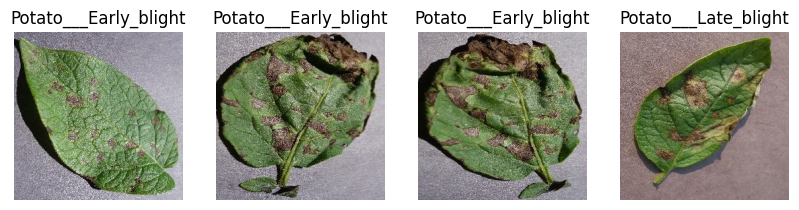

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

we take train => 80%
we tak test , validation => 20% [both have 10-10% data]

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
test_ds = dataset.skip(54)

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# IMPORTANT THAT FOR OUR CUSTOMN IMAGE MODEL WONT GIVE THE ERROR 

In [17]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
) # we used the history as we need to plot the graph with it 

Epoch 1/10


54/54 [==============================] - 68s 1s/step - loss: 0.9183 - accuracy: 0.4850 - val_loss: 0.8774 - val_accuracy: 0.4896
Epoch 2/10
54/54 [==============================] - 61s 1s/step - loss: 0.7887 - accuracy: 0.5845 - val_loss: 0.5713 - val_accuracy: 0.7396
Epoch 3/10
54/54 [==============================] - 60s 1s/step - loss: 0.4712 - accuracy: 0.7986 - val_loss: 0.6200 - val_accuracy: 0.6667
Epoch 4/10
54/54 [==============================] - 61s 1s/step - loss: 0.3676 - accuracy: 0.8443 - val_loss: 0.4202 - val_accuracy: 0.8177
Epoch 5/10
54/54 [==============================] - 61s 1s/step - loss: 0.3389 - accuracy: 0.8628 - val_loss: 0.3120 - val_accuracy: 0.8490
Epoch 6/10
54/54 [==============================] - 61s 1s/step - loss: 0.2518 - accuracy: 0.8906 - val_loss: 0.2700 - val_accuracy: 0.8698
Epoch 7/10
54/54 [==============================] - 61s 1s/step - loss: 0.2320 - accuracy: 0.9109 - val_loss: 0.1937 - val_accuracy: 0.9271
Epoch 8/10
54/54 [

In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 283ms/step - loss: 0.0928 - accuracy: 0.9727


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [24]:
history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 660ms/step
predicted label: Potato___Early_blight


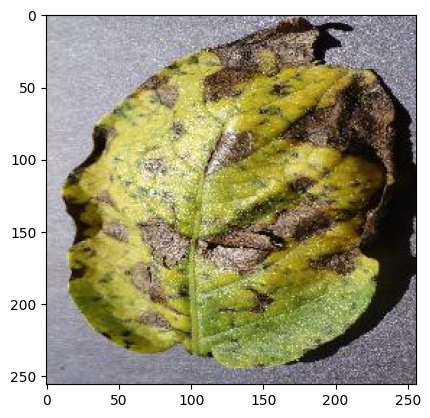

In [25]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 69ms/step


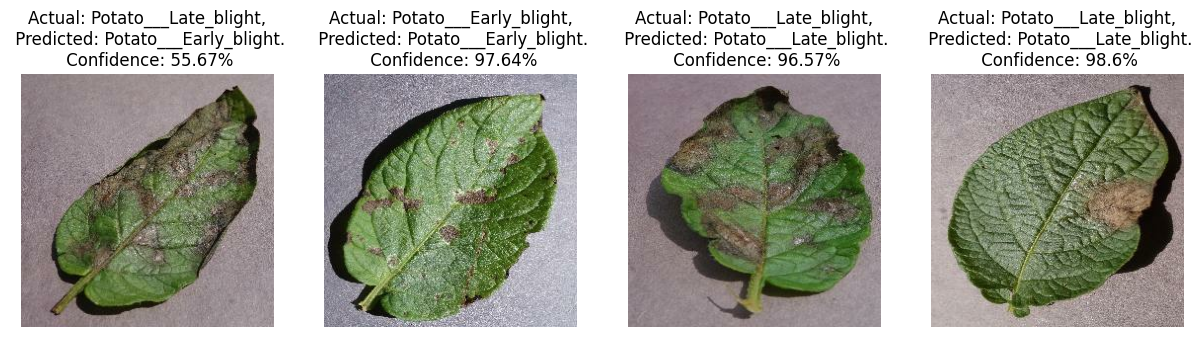

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [28]:
model.save("model_v1.keras", save_format="keras")